In [10]:
import autograd.numpy as np
from autograd import grad, hessian
from scipy.optimize import minimize, approx_fprime
from scipy.optimize import NonlinearConstraint
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [11]:
def obj_func(X):
    
    x1, x2, x3, x4, x5, x6, x7 = X
    Di = x1
    Do = x2
    Ti = x3
    A = x4
    Lt = x5
    Vw = x6
    To = x7

    # constants
    Pr_l = 4.34
    Pr_w = 6.90
    Vl = 5  # ft/s
    T_wi = 323
    #T_we = 273
    #T_l = 273
    Ta = 242
    k = 0.00257
    v = 1.05*0.00001 # visocosity of fluid - same for both 
    r = 1.4*0.00001  # roughness of the pipe

    # variable
    Ai = (np.pi*Di**2)/4
    Ao = (np.pi*Do**2)/4
    Re_i = (Vl * Di)/v
    Re_o = (Vw * Do)/v
    
    w1 = 0.5
    #To = A*np.log(Do/Di) + Ti
    S = np.log10(Re_i/1.816*np.log10(1.1*Re_i/np.log10(1+1.1*Re_i)))
    f = -2*np.log10(2.18*S/Re_i + r/(3.71*Di))
    Nu_i = ((f/2)*(Re_i-1000)*Pr_l)/(1+12.7*(Pr_l**(2/3)-1)*(f/2)**0.5)
    Nu_o = 0.0237*Re_o**0.618*Pr_w**(1/3)
    h_i = Nu_i*k/Di
    h_o = Nu_o*k/Do

    part_1 = 1/(h_i*Ai*(Ti - Ta))
    part_2 = (1/(2*np.pi*k*Lt))*A*np.log(Do/Di)
    part_3 = 1/(h_o*Ao*(T_wi - To))

    therm_val = part_1 + part_2 + part_3

    shell_val = 2.66175 * Lt * Do**2 * 5

    obj_val = w1*shell_val + (1-w1)*therm_val
    
    return obj_val

def grad_obj_func(X):
    
    grad_fun = grad(obj_func)
    grad_val_fun = grad_fun(X)
    
    return grad_val_fun

def hess_obj_func(X):
    H_fun = hessian(obj_func)
    H_matrix_fun = H_fun(X)
    return H_matrix_fun

# Functions for constraint 1
def constraint_1(X):
    
    x1, x2, x3, x4, x5, x6, x7 = X  # Fix variable name
    Di = x1
    Do = x2
    Ti = x3
    A = x4
    Lt = x5
    Vw = x6
    To = x7
    
    T_wi = 323
    T_we = 273
    m = 2.94
    cp = 0.998
    k = 0.00257

    Q = m*cp*(T_wi - T_we)
    #To = A*np.log(Do/Di) + Ti
    const_val = (Lt/Vw)  - (Q*(Do - Di))/(k*(To - Ti)*2*np.pi*Do*Lt)  # Fix formula
    
    return const_val


# Functions for constraint 1
def constraint_2(X):
    
    x1, x2, x3, x4, x5, x6, x7 = X  # Fix variable name
    Di = x1
    Do = x2
    Ti = x3
    A = x4
    Lt = x5
    Vw = x6
    To = x7
    
    const_val_2 = To - ((A*np.log(Do/Di)) + Ti)  # Fix formula
    
    return const_val_2

# Functions for constraint 1
def constraint_3(X):
    
    x1, x2, x3, x4, x5, x6, x7 = X  # Fix variable name
    Di = x1
    Do = x2
    Ti = x3
    A = x4
    Lt = x5
    Vw = x6
    To = x7
    
    const_val_3 = Do - Di - 0.0128 # Fix formula
    
    return const_val_3

# Functions for constraint 1
def constraint_4(X):
    
    x1, x2, x3, x4, x5, x6, x7 = X  # Fix variable name
    Di = x1
    Do = x2
    Ti = x3
    A = x4
    Lt = x5
    Vw = x6
    To = x7
    
    const_val_4 = Di - Do + 0.0215  # Fix formula
    
    return const_val_4

# Functions for constraint 1
def constraint_5(X):
    
    x1, x2, x3, x4, x5, x6, x7 = X  # Fix variable name
    Di = x1
    Do = x2
    Ti = x3
    A = x4
    Lt = x5
    Vw = x6
    To = x7
    #To = A*np.log(Do/Di) + Ti
    const_val_5 = To - Ti - 1  # Fix formula
    
    return const_val_5


In [12]:

# Define the values of the independent variables
X0 = np.array([0.1, 0.21, 245, 30, 11, 0.11, 322])

# Define bounds for variables
bounds = ((0.025, 0.416),  # Di
          (0.0416, 0.429),  # Do
          (243, 322),  # Ti
          (0, 41),  # A
          (5, 12),  # Lt
          (0.1, 3.0),  # Vw
          (273, 322))  # To

# Define multiple constraints
constraints = [{'type': 'ineq', 'fun': constraint_1},
               {'type': 'eq', 'fun': constraint_2},
               {'type': 'ineq', 'fun': constraint_3},
               {'type': 'ineq', 'fun': constraint_4},
              {'type': 'ineq', 'fun': constraint_5}]

# Initialize lists to store convergence data
itr_list = []
obj_list = []
grad_list = []
value_list = []
grad_lag = []

def callback_function(xk, state):
    itr_list.append(state.niter)
    obj_list.append(obj_func(xk))
    grad_lag.append(state.optimality)
    value_list.append(xk)
    grad_list.append(np.linalg.norm(grad_obj_func(xk)))
    callback_function.iteration += 1

callback_function.iteration = 0  # Initialize iteration count

# Minimize the objective function
#result = minimize(obj_func, X0, method='SLSQP', bounds=bounds, constraints=constraints, callback=callback_function)
result = minimize(obj_func, X0, method='trust-constr', jac=grad_obj_func, hess=hess_obj_func, \
               bounds=bounds, constraints=constraints, \
                  options={'gtol': 1e-8,'xtol':1e-12, 'maxiter': 300, 'verbose': 3}, \
                  callback=callback_function);

# Extract the first and second elements of value_list
Di_val = [value[0] for value in value_list]
Do_val = [value[1] for value in value_list]
A_val = [value[3] for value in value_list]
Ti_val = [value[2] for value in value_list]
To_val = [value[6] for value in value_list]

# Print the result
print("Optimal solution:", result.x)


gov_val = []
for i in range(len(Ti_val)):
    gov = To_val[i] - (A_val[i]*np.log(Do_val[i]/Di_val[i]) + Ti_val[i])
    gov_val.append(gov)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +2.9070e+02 | 1.00e+00 | 4.02e+02 | 5.47e+01 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   2   |   4   | +2.4636e+02 | 7.00e+00 | 9.19e+01 | 3.16e+01 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |   3   |  10   | +3.5135e+02 | 7.71e+00 | 2.78e+01 | 1.23e+01 | 9.65e+00 |  1.00e-01   |   1   |
|   4   |   4   |  16   | +3.1716e+02 | 9.29e+00 | 1.73e+01 | 1.69e+00 | 9.65e+00 |  1.00e-01   |   1   |
|   5   |   5   |  22   | +4.2760e+02 | 9.63e+00 | 2.79e+01 | 1.66e+00 | 1.11e+02 |  1.00e-01   |   1   |
|   6   |   6   |  27   | +6.2275e+02 | 9.63e+00 | 4.24e+01 | 1.08e+00 | 1.11e+02 |  1.00e-01   |   4   |
|   7   |   7   |  32   | +6.2275e+02 | 9.63e-01 | 4.24e+01 | 1.08e+00 | 1.11e+02 |  1.00e-01   |   4   |
|   8   |   8   |  37   | +6.2275e+02 | 9.63e-

|  83   |  97   |  176  | +4.0563e+01 | 2.87e+00 | 3.19e+00 | 8.53e-04 | 1.97e+02 |  1.00e-01   |   2   |
|  84   |  99   |  178  | +4.0563e+01 | 2.87e-01 | 3.19e+00 | 8.53e-04 | 1.97e+02 |  1.00e-01   |   2   |
|  85   |  101  |  179  | +3.9484e+01 | 2.01e+00 | 3.18e+00 | 3.37e-04 | 1.97e+02 |  1.00e-01   |   2   |
|  86   |  103  |  180  | +3.9484e+01 | 2.01e-01 | 3.18e+00 | 3.37e-04 | 1.97e+02 |  1.00e-01   |   2   |
|  87   |  105  |  181  | +3.8727e+01 | 1.41e+00 | 3.17e+00 | 1.28e-04 | 1.97e+02 |  1.00e-01   |   2   |
|  88   |  107  |  182  | +3.8727e+01 | 1.41e-01 | 3.17e+00 | 1.28e-04 | 1.97e+02 |  1.00e-01   |   2   |
|  89   |  109  |  183  | +3.8197e+01 | 9.86e-01 | 3.16e+00 | 4.70e-05 | 1.97e+02 |  1.00e-01   |   2   |
|  90   |  111  |  184  | +3.4696e+01 | 9.86e-01 | 3.10e+00 | 1.36e-02 | 1.97e+02 |  1.00e-01   |   2   |
|  91   |  113  |  185  | +3.1278e+01 | 1.97e+00 | 3.03e+00 | 1.73e-02 | 1.97e+02 |  1.00e-01   |   2   |
|  92   |  115  |  187  | +3.1278e+01 | 1.97e-

|  163  |  221  |  261  | +1.2128e+01 | 8.39e-01 | 1.24e-01 | 1.60e-06 | 1.97e+02 |  1.00e-01   |   2   |
|  164  |  223  |  262  | +1.1725e+01 | 1.68e+00 | 7.26e-02 | 2.90e-04 | 1.97e+02 |  1.00e-01   |   2   |
|  165  |  224  |  264  | +1.1662e+01 | 1.68e+00 | 2.64e-02 | 6.67e-04 | 1.97e+02 |  1.00e-01   |   2   |
|  166  |  225  |  266  | +1.1684e+01 | 1.68e+00 | 7.27e-02 | 1.68e-03 | 1.97e+02 |  1.00e-01   |   2   |
|  167  |  227  |  268  | +1.1689e+01 | 3.36e+00 | 9.35e-02 | 4.77e-06 | 1.97e+02 |  1.00e-01   |   2   |
|  168  |  229  |  270  | +1.1644e+01 | 3.36e+00 | 1.24e-01 | 1.34e-05 | 1.97e+02 |  1.00e-01   |   4   |
|  169  |  231  |  273  | +1.1383e+01 | 6.08e+00 | 1.47e-01 | 9.72e-06 | 1.97e+02 |  1.00e-01   |   4   |
|  170  |  233  |  275  | +1.1383e+01 | 6.08e-01 | 1.47e-01 | 9.72e-06 | 1.97e+02 |  1.00e-01   |   2   |
|  171  |  234  |  277  | +1.1317e+01 | 1.22e+00 | 1.42e-01 | 1.96e-04 | 1.97e+02 |  1.00e-01   |   2   |
|  172  |  236  |  279  | +1.1317e+01 | 1.22e-

|  251  |  355  |  415  | +8.7210e+00 | 1.03e+06 | 1.36e-06 | 1.06e-11 | 1.00e+00 |  2.56e-07   |   4   |
|  252  |  356  |  416  | +8.7210e+00 | 1.03e+06 | 1.23e-06 | 5.68e-14 | 1.00e+00 |  2.56e-07   |   4   |
|  253  |  358  |  417  | +8.7210e+00 | 1.03e+06 | 2.56e-07 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  254  |  359  |  423  | +8.7210e+00 | 1.03e+06 | 2.40e-07 | 1.33e-09 | 1.00e+00 |  2.56e-07   |   1   |
|  255  |  359  |  423  | +8.7210e+00 | 5.17e+06 | 2.05e-07 | 1.33e-09 | 1.00e+00 |  5.12e-08   |   0   |
|  256  |  360  |  425  | +8.7210e+00 | 5.17e+06 | 1.16e-07 | 6.20e-12 | 1.00e+00 |  5.12e-08   |   4   |
|  257  |  361  |  431  | +8.7210e+00 | 5.17e+06 | 1.17e-07 | 2.01e-10 | 1.00e+00 |  5.12e-08   |   1   |
|  258  |  362  |  432  | +8.7210e+00 | 5.17e+06 | 4.06e-09 | 0.00e+00 | 1.00e+00 |  5.12e-08   |   4   |

`gtol` termination condition is satisfied.
Number of iterations: 258, function evaluations: 362, CG iterations: 432, optimality: 4.06e-09, constraint v

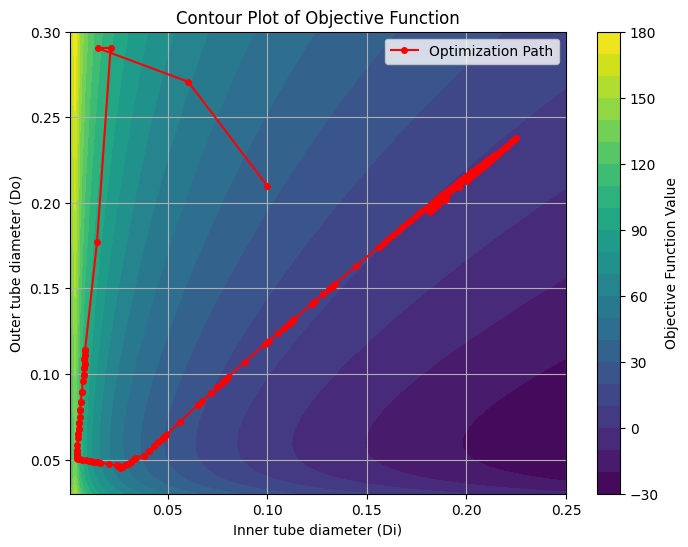

In [13]:
# Define the ranges for Do and Lt
Do_values = np.linspace(0.03, 0.3, 100)  # Range for Do
Di_values = np.linspace(0.001, 0.25, 100)  # Range for Di

# Create a grid of Do and Lt values
Do_grid, Di_grid = np.meshgrid(Do_values, Di_values)

# Compute the objective function values for each combination of Do and Lt
obj_values = obj_func([0.05, 0.1, 274, 40, 0.58, 0.5, 322])  # Assuming initial values for other variables
Z = np.array([[obj_func([Di, Do, 272, 13.7, 12, 0.226, 273]) for Do in Do_values] for Di in Di_values])

# Plot the contour
plt.figure(figsize=(8, 6))
contour = plt.contourf(Di_grid, Do_grid, Z, cmap='viridis', levels=20)
cbar = plt.colorbar(contour)
cbar.set_label('Objective Function Value')
plt.xlabel('Inner tube diameter (Di)')
plt.ylabel('Outer tube diameter (Do)')
plt.title('Contour Plot of Objective Function')

# Plot the optimization path
plt.plot(Di_val, Do_val, color='red', marker='o', linestyle='-', label='Optimization Path',markersize=4)

# Show the legend
plt.legend()
#plt.savefig('Optimization_path.png',dpi = 300)
# Show the plot
plt.grid(True)
plt.show()

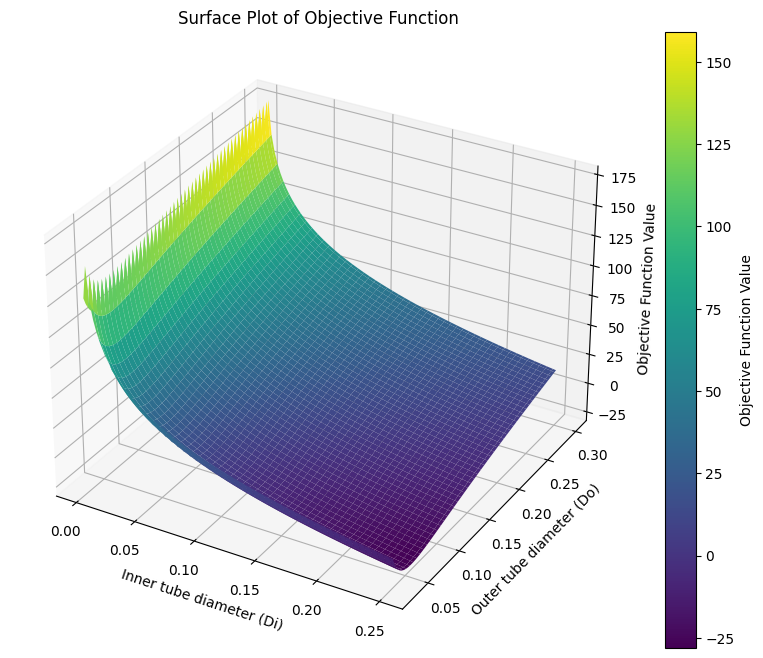

In [14]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(Di_grid, Do_grid, Z, cmap='viridis', edgecolor='none')
cbar = fig.colorbar(surf)
cbar.set_label('Objective Function Value')
ax.set_xlabel('Inner tube diameter (Di)')
ax.set_ylabel('Outer tube diameter (Do)')
ax.set_zlabel('Objective Function Value')
ax.set_title('Surface Plot of Objective Function')
#plt.savefig('Surface_plot.png',dpi = 300)
plt.show()

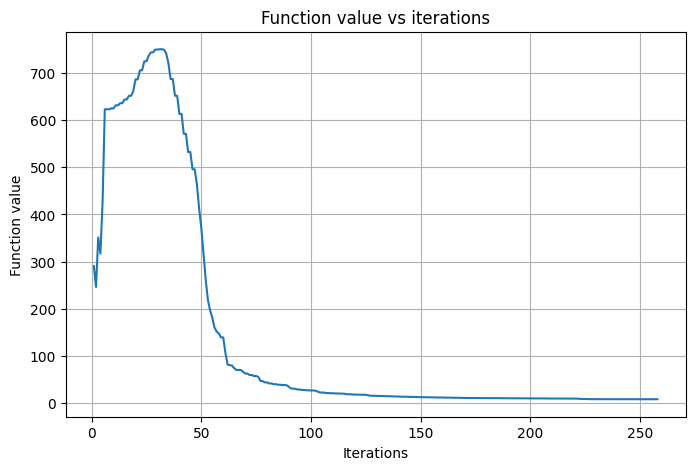

In [15]:
fig = plt.figure(figsize=(8, 5))
plt.plot(itr_list,obj_list)
plt.xlabel('Iterations')
plt.ylabel('Function value')
plt.title('Function value vs iterations')
#plt.savefig('fun_value.png',dpi = 300)
# Show the plot
plt.grid(True)
plt.show()

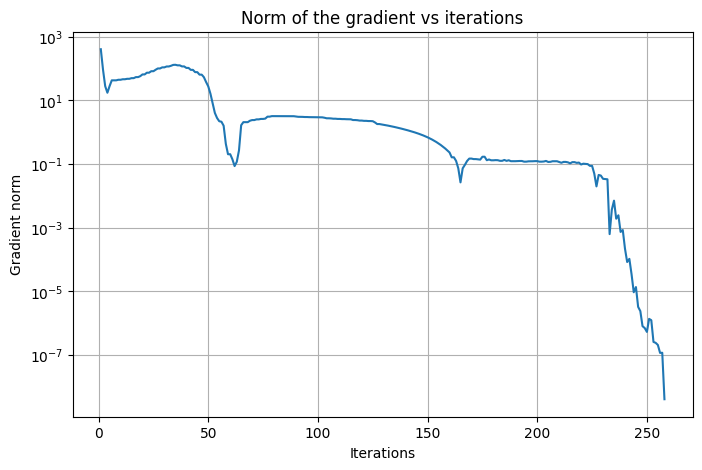

In [16]:
fig = plt.figure(figsize=(8, 5))
plt.plot(itr_list,grad_lag)
plt.xlabel('Iterations')
plt.ylabel('Gradient norm')
plt.yscale('log') 
plt.title('Norm of the gradient vs iterations')
#plt.savefig('grad_value.png',dpi = 300)
# Show the plot
plt.grid(True)
plt.show()

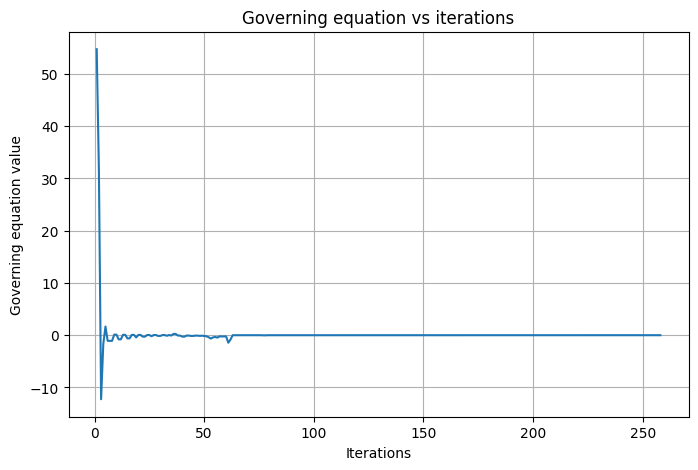

In [17]:
fig = plt.figure(figsize=(8, 5))
plt.plot(itr_list,gov_val)
plt.xlabel('Iterations')
plt.ylabel('Governing equation value')
plt.title('Governing equation vs iterations')
#plt.savefig('gov_value.png',dpi = 300)
# Show the plot
plt.grid(True)
plt.show()

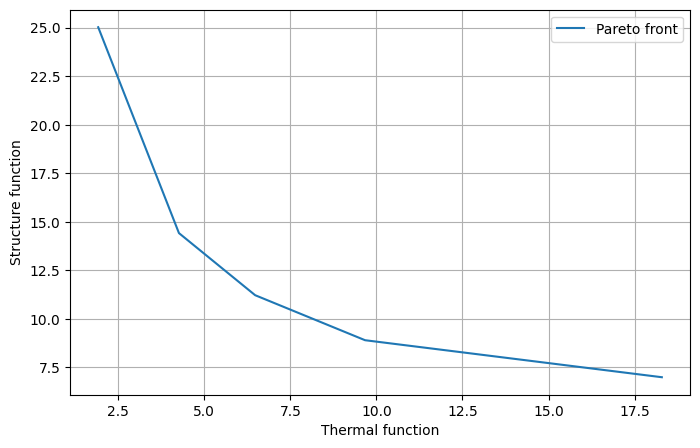

In [18]:
X01 = [0.3256, 0.33844, 272, 25.938, 11.999, 0.419, 273]
X03 = [0.2332, 0.24608, 272, 18.7211, 11.999, 0.3047, 273]
X05 = [0.188, 0.2014, 272, 15.23, 11.999, 0.249, 273]
X07 = [0.1506, 0.1634, 271.93, 13.06, 11.999, 0.215, 273]
X09 = [0.0968, 0.1096, 271.1, 14.901, 11.999, 0.251, 273]

X_value = np.array([X01,X03,X05,X07,X09])

shell_value = []
therm_value = []

for i in range(len(X_value)):
    
    Di = X_value[i][0]
    Do = X_value[i][1]
    Ti = X_value[i][2]
    A = X_value[i][3]
    Lt = X_value[i][4]
    Vw = X_value[i][5]
    To = X_value[i][6]

    # constants
    Pr_l = 4.34
    Pr_w = 6.90
    Vl = 5  # ft/s
    T_wi = 323
    #T_we = 273
    #T_l = 273
    Ta = 242
    k = 0.00257
    v = 1.05*0.00001 # visocosity of fluid - same for both 
    r = 1.4*0.00001  # roughness of the pipe

    # variable
    Ai = (np.pi*Di**2)/4
    Ao = (np.pi*Do**2)/4
    Re_i = (Vl * Di)/v
    Re_o = (Vw * Do)/v

    S = np.log10(Re_i/1.816*np.log10(1.1*Re_i/np.log10(1+1.1*Re_i)))
    f = -2*np.log10(2.18*S/Re_i + r/(3.71*Di))
    Nu_i = ((f/2)*(Re_i-1000)*Pr_l)/(1+12.7*(Pr_l**(2/3)-1)*(f/2)**0.5)
    Nu_o = 0.0237*Re_o**0.618*Pr_w**(1/3)
    h_i = Nu_i*k/Di
    h_o = Nu_o*k/Do

    part_1 = 1/(h_i*Ai*(Ti - Ta))
    part_2 = (1/(2*np.pi*k*Lt))*A*np.log(Do/Di)
    part_3 = 1/(h_o*Ao*(T_wi - To))

    therm_val = part_1 + part_2 + part_3

    shell_val = 2.66175 * Lt * Do**2 * 5

    shell_value.append(shell_val)
    therm_value.append(therm_val)
    
fig = plt.figure(figsize=(8, 5))
plt.plot(shell_value,therm_value, label = 'Pareto front')
plt.xlabel('Thermal function')
plt.ylabel('Structure function')
plt.legend()
#plt.savefig('pareto_value.png',dpi = 300)
# Show the plot
plt.grid(True)
plt.show()